Primero importamos las librerías que vamos a necesitar

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

Ahora introducimos la ruta en la que guardamos el archivo con los datos que se analizarán

In [4]:
df = pd.read_csv('/home/luis-loreto/Documentos/Python/Titanic/Tablas/train.csv')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Iniciamos con el análisis exploratorio. Vemos cuántos registros tiene cada variable. Se puede observar que son 11 variables independientes y una dependiente: Survived. Ésta última será la variable para el aprendizaje en nuestro modelos de machine learning. 

In [51]:
df.count().reset_index(name="Total")

,index,Total
0,PassengerId,891
1,Survived,891
2,Pclass,891
3,Name,891
4,Sex,891
5,Age,891
6,SibSp,891
7,Parch,891
8,Ticket,891
9,Fare,891


Descartamos la variable Cabin debido a que el porcentaje de missings es muy alto. Para usar Age vamos a requerir un método de imputación.

Podemos observar que son 891 observaciones en nuestro conjunto de entrenamiento, no obstante, se trata de una base desbalanceada, pues las variables "Age", "cabin" y "Embarked" presentan missings, es decir, registros sin informaición. Si queremos trabajar con alguna de estas tres variables debemos buscar un metodo para reemplazar los registros faltantes, a esto se le conoce como imputación.

Continuando con el análisis exploratorio, podemos empezar a observar cuántos sobrevivientes hubo agrupando por clase.

In [52]:
Pclass = df.groupby(["Survived", "Pclass"])["Survived"].count().reset_index(name="Cantidad")

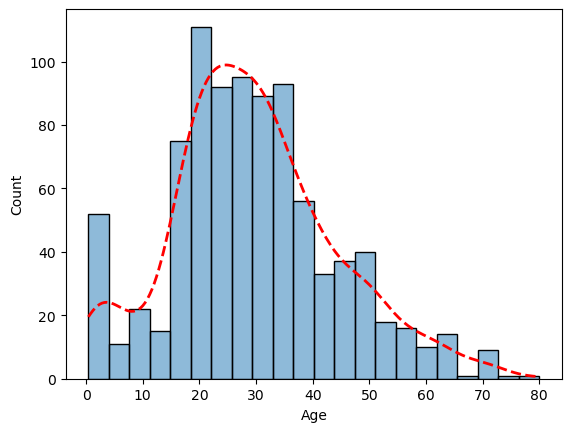

In [54]:
sns.histplot(x = df['Age'], kde = True, line_kws = {'linestyle' : 'dashed', 
                                                 'linewidth' : '2'}).lines[0].set_color('red')

Ahora bien, podemos hacer una lift table, algo muy común en el análisis de riesgos como una primera métrica descriptiva de cómo se ajusta la variable a nuestra "marca de malo", en este caso Survived

In [55]:
# Pivotear el DataFrame
tabla1 = Pclass.pivot_table(index='Pclass', columns='Survived', values='Cantidad', aggfunc='sum', fill_value=0)
tabla1['Total'] = (tabla1[0] + tabla1[1])
tabla1["% de sobrevivientes"] = (tabla1[1] / tabla1['Total'])
tabla1

Survived,0,1,Total,% de sobrevivientes
Pclass,,,,
1,80,136,216,0.629630
2,97,87,184,0.472826
3,372,119,491,0.242363


Se puede observar que la proporción de sobrevivientes aumenta a medida que la variable Pclase también lo hace. Digamos que esta es una primera aproximación, es una buena manera descriptiva de ver la relación entre una variable binaria y una ordinal categórica. No obstante, son 10 las variables que debemos analizar para saber cuáles de ellas se pueden usar para generar un modelo que prediga la supervivencia

Iniciemos con la exploración de cada variable. A pesar de que la intución nos pueda sugerir que variables como "Name" no deberían ser relevantes para explicar Survived, asumamos que no tenemos nada de teoría, es decir, es un trabajo totalmente empírico y exploratorio. En ciencias sociales, la teoría sirve para tener una dirección y no andar a ciegas en un mar de datos, careciendo de cualquier indicio de casualidad o de explicación. La teoría puede ser algo fantástico (en el buen sentido), pero en nuestro ejercicio prescindiremos totalmente de ella.

Vamos a contar el número de observaciones según Pclass

In [22]:
df.groupby(["Pclass"])["Pclass"].count().reset_index(name="Cantidad")

,Pclass,Cantidad
0,1,216
1,2,184
2,3,491


In [23]:
#PassengerId
df.groupby(["Sex"])["Sex"].count().reset_index(name="Cantidad")

,Sex,Cantidad
0,female,314
1,male,577


La variable ticket, a primera vista no nos brinda información relevante, pero si observamos más detenidamente, se podrían encontrar varios patrones. Se podrían clasificar de la siguiente manera:
Tickets sin letra
Tickets que inician con alguna letra

Lo más probable es que estos registros tengan errores y se hayan llevado a cabo. Esta variable requiere un trabajo de limpieza y depuración. 
Primero que nada, observamos uqe hay tickets que de 4, 5 o 6 dígitos. No obstante, todos parecen tener continuidad en lo que respecta a los dos primeros dígitos. Por lo tanto, los tíckets sin letra se covertiran en tickets que consistan en los dos primeros dígitos.
Luego están los que inician con letra. Al parecer, los que inician con A, pueden ir seguidos de un 5 o un 4, por lo que estos tickets serán renombrados como A5 o A4 según corresponda. Luego están los que inician con C, CA, FC, 

Ahora vamos a iniciar con la magia de Python. Crearemos una pequeña función que detecte si hay espacios en una variable y que elimine la parte que precede a dicho espacio! 

In [56]:
def primer_caracter_despues_de_eliminar(texto):
    # Eliminar el contenido antes del primer espacio
    parte_despues_espacio = texto.split(' ', 1)[1] if ' ' in texto else texto
    # Retornar el primer carácter de esa parte
    return parte_despues_espacio[0] if parte_despues_espacio else ''


In [57]:
df['Ticket2'] = df['Ticket'].apply(primer_caracter_despues_de_eliminar)

In [58]:
df.groupby(["Ticket2"])["Ticket2"].count().reset_index(name="Cantidad")

,Ticket2,Cantidad
0,1,231
1,2,242
2,3,355
3,4,15
4,5,8
5,6,14
6,7,15
7,8,3
8,9,3
9,B,1


Nuestra última variable problemática es Age, pues presenta valores faltantes y se deben imputar para poderrealizar un modelo. Nuestro método de imputación

Para observar qué observaciones tienen valores faltantes en variable "Age" usamos el siguiente código

In [29]:
def hot_deck_imputation(df):
    for column in df.columns:
        # Encontrar índices donde hay valores faltantes
        missing_indices = df[df["Age"].isnull()].index
        
        for idx in missing_indices:
            # Seleccionar filas no faltantes
            non_missing_values = df["Age"].dropna()
            # Elegir un valor aleatorio de las filas no faltantes
            random_value = non_missing_values.sample(n=1).values[0]
            # Imputar el valor aleatorio en el índice correspondiente
            df.at[idx, "Age"] = random_value
            
    return df


In [30]:
df_imputado = hot_deck_imputation(df)

In [31]:
df_imputado.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3
5,6,0,3,"Moran, Mr. James",male,20.5,0,0,330877,8.4583,NaN,Q,3
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,3
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2


In [66]:
one_hot = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)

In [34]:
one_hot.head(3)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket2,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,2,1.0,0.0,1.0,0.0,1.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0.0,0.0,0.0,0.0,0.0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,3,0.0,0.0,1.0,0.0,1.0


In [35]:
datos = one_hot[["Survived", "Age", "SibSp", "Parch", "Fare", "Ticket", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]

In [36]:
datos.head(3)

,Survived,Age,SibSp,Parch,Fare,Ticket,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,A/5 21171,1.0,0.0,1.0,0.0,1.0
1,1,38.0,1,0,71.2833,PC 17599,0.0,0.0,0.0,0.0,0.0
2,1,26.0,0,0,7.9250,STON/O2. 3101282,0.0,0.0,1.0,0.0,1.0


In [37]:
datos.dtypes

Survived        int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Ticket         object
Sex_male      float64
Pclass_2      float64
Pclass_3      float64
Embarked_Q    float64
Embarked_S    float64
dtype: object

In [69]:
X = one_hot[["Age", "SibSp", "Parch", "Fare", "Ticket2", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]
y = one_hot[["Survived"]]

In [70]:
model = LogisticRegression()

In [63]:
df[df['Ticket2'].str.startswith(('L','B'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket2
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S,L
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,L
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S,L
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C,B
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S,L


In [64]:
df['Ticket2'] = df['Ticket2'].apply(lambda x: '1' if x.startswith(('B', 'L'))
                                   else x)

In [65]:
df.groupby(["Ticket2"])["Ticket2"].count().reset_index(name="Cantidad")

,Ticket2,Cantidad
0,1,236
1,2,242
2,3,355
3,4,15
4,5,8
5,6,14
6,7,15
7,8,3
8,9,3


In [71]:
model.fit(X, y)

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [72]:
y = model.predict(X)

In [78]:
#info del modelo

print("Intercept:", model.intercept_)
print("Coeficiente:", list(zip(X.columns, model.coef_.flatten(), )))
print("Accuracy de entrenamiento:", model.score(X, y))


Intercept: [3.43714258]
Coeficiente: [('Age', -0.022935490871896533), ('SibSp', -0.2893833491290594), ('Parch', -0.11813464437050543), ('Fare', 0.005115148810818776), ('Ticket2', -0.26910428934008923), ('Sex_male', -2.682951018657286), ('Pclass_2', -0.30065855581704626), ('Pclass_3', -1.080809904806344), ('Embarked_Q', 0.24200619100206233), ('Embarked_S', -0.46995892524712796)]
Accuracy de entrenamiento: 1.0
